In [1]:
from matplotlib import cm, colors, pyplot as plt
import metaworld
import torch
from torch import nn
import copy
import ray
import numpy as np
import seaborn as sns

from nupic.embodied.utils.garage_utils import create_policy_net
from nupic.embodied.multitask.samplers.gpu_sampler import SamplerEvalOnly
from nupic.embodied.multitask.hooks.sparse_viz import (
    AverageSegmentActivationsHook,
    HiddenActivationsPercentOnHook,
    CombinedSparseVizHook
)

from garage.experiment.task_sampler import MetaWorldTaskSampler

from nupic.embodied.utils.parser_utils import merge_args
sys.path.append("/Users/lsouza/nta/nupic.embodied/projects/multitask")
from args_parser import create_exp_parser
from experiments import CONFIGS

import numpy
import torch

from scipy.spatial.distance import cosine


objc[81029]: Class GLFWApplicationDelegate is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x12c327778) and /Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x12c3e0740). One of the two will be used. Which one is undefined.
objc[81029]: Class GLFWWindowDelegate is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x12c327700) and /Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x12c3e0768). One of the two will be used. Which one is undefined.
objc[81029]: Class GLFWContentView is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x12c3277a0) and /Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/glfw/libglfw.3.dylib (0x12c3e07b8). One of the two will be used. Which one is undefined.
objc[81029]: Class GLFWWindow is implemented in both /Users/lsouza/.mujoco/mujoco200/bin/libglfw.3.dylib (0x12c327818) and /Users/lsou

# MLP-Dendrites Comparison

In [2]:
class HiddenActivationsPercentOnHookMLP(HiddenActivationsPercentOnHook):
    def attach(self, network):
        network.module.mean_log_std._layers[1].register_forward_hook(self.activation_hook_fn)     

def get_updated_policy(policy, hook):
    with torch.no_grad():
        updated_policy = copy.deepcopy(policy)
    updated_policy.eval()
    hook(updated_policy)
    return updated_policy

def init_experiment(state_path, config, mlp=False):
    mt_env = metaworld.MT10(seed=42)
    train_task_sampler = MetaWorldTaskSampler(
        mt_env, "train", add_env_onehot=True
    )
    mt_train_envs = train_task_sampler.sample(10)
    env = mt_train_envs[0]()

    experiment_state = torch.load(state_path, map_location=torch.device('cpu'))

    exp_parser = create_exp_parser()
    trainer_args = merge_args(exp_parser.parse_dict(CONFIGS[config]))
 
    env = mt_train_envs[0]()
    policy = create_policy_net(env_spec=env.spec, net_params=trainer_args)

    policy.load_state_dict(experiment_state["algorithm"]["policy"])

    if mlp:
        print("Using MLP network")
        hook = HiddenActivationsPercentOnHookMLP
    else:
        hook = HiddenActivationsPercentOnHook

    net = get_updated_policy(policy, hook)

    sampler = SamplerEvalOnly(
        agent=net,
        envs=mt_train_envs,
        max_episode_length=env.spec.max_episode_length,
        cpus_per_worker=0.5,
        gpus_per_worker=0,
        workers_per_env=1,
        seed=42,
    )

    return net, sampler

def collect_data(net, sampler):

    samples, hook_data = sampler.obtain_exact_episodes(
        n_eps_per_worker=1,
        agent_update=net,
        collect_hook_data=True,
    )

    data = next(iter(hook_data.values()))

    return data

def get_distances(data):
    distances = np.zeros((10,10))
    for i in range(len(data)):
        for j in range(len(data)):
            average_acts_i = data[i].mean(dim=0)
            average_acts_j = data[j].mean(dim=0)
            distances[i][j] = cosine(average_acts_i, average_acts_j)

    return distances

def calculate_avg_distances(data, num_samples=40):
    distances_same_task = []
    distances_other_task = []
    for i in range(len(data)):
        for j in range(len(data)):
            if i == j:
                distances_per_type = distances_same_task
            else:
                distances_per_type = distances_other_task
            acts_i = data[i]
            acts_j = data[j]
            for x in range(num_samples):# range(acts_i.shape[0]):
                for y in range(num_samples): # range (acts_j.shape[0]):
                    distances_per_type.append(cosine(acts_i[x, :], acts_j[y, :]))
    print("\nDistance same task: {:.4f}, across tasks: {:.4f}\n".format(
        np.mean(distances_same_task), np.mean(distances_other_task)
    ))          

def report(state_path, config, mlp=False, num_samples=40):
    net, sampler = init_experiment(state_path, config, mlp=mlp)
    data = collect_data(net, sampler)
    distances = get_distances(data)
    calculate_avg_distances(data, num_samples=num_samples)
    sns.heatmap(distances)
    return net, sampler, data, distances

/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/garage/experiment/deterministic.py:36: UserWarning: Enabeling deterministic mode in PyTorch can have a performance impact when using GPU.
  warnings.warn(
/Users/lsouza/miniconda3/envs/multitask/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))

Distance same task: 0.3773, across task: 0.9194



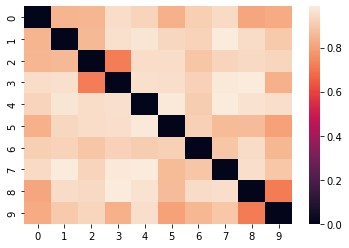

In [3]:
state_path = "/Users/lsouza/nta/results/no_overlap_10d_abs_max_signed_with_plots-idma329/experiment_state.p"
config = "no_overlap_10d_abs_max_signed"
report(state_path, config, mlp=False);

Using MLP network

Distance same task: 0.3455, across task: 0.9429



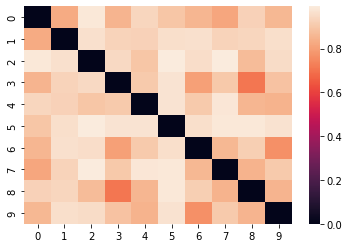

In [4]:
state_path_mlp = "/Users/lsouza/nta/results/new_metaworld_baseline-tvtt157/experiment_state.p"
config_mlp = "new_metaworld_baseline"
report(state_path_mlp, config_mlp, mlp=True);